L'objectif est de comparer trois graphes:
 - Le premier est la valeur des angles labellisés au cours des frames
 - Le second est la valeur prédite des angles au cours des frames
 - Le troisième est la valeur des angles selon une simple régression linéaire sur les X dernières valeurs

Lecture des images de records_good/

In [11]:
import os
import md
import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import preprocess
from pykalman import KalmanFilter

In [12]:
data_dir = "./records_good/"

X = [f for f in os.listdir(data_dir) if
       os.path.isfile(os.path.join(data_dir, f)) and
       (cv2.imread(os.path.join(data_dir, f)) is not None) ]
y = [(int(f.split("_")[1]), float(f.split("_")[5].split(".j")[0])) for f in X]

print(X[0])
print(y[0])

frame_2832_gas_0.4_dir_-0.07049499443826474.jpg
(2832, -0.07049499443826474)


Récupération des données pour les tracés

In [13]:
# Graphe 1
y = sorted(y, key=(lambda x: x[0]))
g1_time = [x[0] for x in y]
g1_angle = [x[1] for x in y]

In [14]:
# Graphe 2
mod = md.build_model()
mod.load_weights('../models/model-0,0YUV.h5')
x = [(int(x.split("_")[1]), data_dir + x) for x in X]
x = sorted(x, key=(lambda l: l[0]))
x = [l[1] for l in x]

imgs = [img for img in map(cv2.imread, x)]
imgs = [img for img, _ in map(preprocess.preprocess, imgs)]
preds = mod.predict(np.array(imgs))


/home/hippolyte/epita/SCIA/PFE/car_repo/speed_prediction/md.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
/home/hippolyte/epita/SCIA/PFE/car_repo/speed_prediction/md.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
/home/hippolyte/epita/SCIA/PFE/car_repo/speed_prediction/md.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
/home/hippolyte/epita/SCIA/PFE/car_repo/speed_prediction/md.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  model.add(Conv2D(64, 3, 3, activation='elu'))
/home/hippolyte/epita/SCIA/PFE/car_repo/speed_

Affichage des graphes: En rouge le graphe 1, en vert le graphe 2 et en bleu le graphe 3.

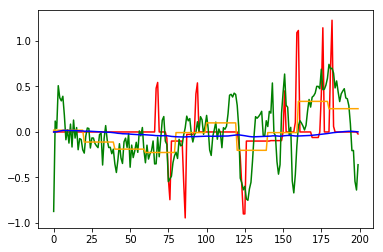

In [66]:
range_inf, range_sup = 0, 200
# nb frame per group is (sup - inf) / nb_group
nb_group = 10

plt.plot(g1_time[range_inf:range_sup], g1_angle[range_inf:range_sup], c='red')
plt.plot(g1_time[range_inf:range_sup], preds[range_inf:range_sup], c='green')
cut = np.split(np.asarray(preds[range_inf:range_sup]), nb_group)

# fonction escalier
p_stair = np.array([np.ones((range_sup - range_inf) // nb_group) * np.mean(x) for x in cut]).flatten()
plt.plot(g1_time[range_inf:range_sup], p_stair, c='orange')

# fonction kalman
# intial parameters
n_iter = range_sup - range_inf
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = preds[range_inf:range_sup] # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 10**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]
    
    
plt.plot(xhat, c='blue')
plt.show()

# 